In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_column',None,'display.max_rows',None)

In [69]:
data=pd.read_csv('Train.csv')
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [8]:
data.shape

(13320, 9)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [21]:
data.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [18]:
data.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [19]:
data.describe(include='object')

,area_type,availability,location,size,society,total_sqft
count,13320,13320,13319,13304,7818,13320
unique,4,81,1305,31,2688,2117
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200
freq,8790,10581,540,5199,80,843


## EDA

<AxesSubplot:>

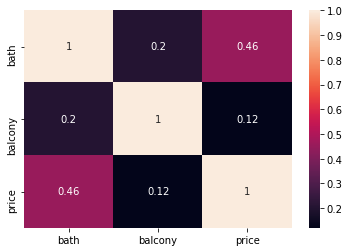

In [400]:
corr=data.corr()
sns.heatmap(corr,annot=True)

Price is positively correlated to bath and balcony

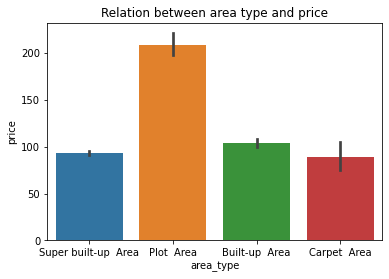

In [6]:
sns.barplot(x='area_type',y='price',data=data)
plt.title('Relation between area type and price')
plt.show()

This column shows tha area that is available for posession. 
1. Plot area is preferred
2. Built up area as it included the parts of building that can be utilized
3. Super built up area
4. Carpet area

**Availability**<br>
We shall categorize this into ready to move and not yet ready to move (a date for moving in is given)

In [70]:
data['availability'].value_counts()

Ready To Move           10581
18-Dec                    307
18-May                    295
18-Apr                    271
18-Aug                    200
19-Dec                    185
18-Jul                    143
18-Mar                    131
18-Jun                     99
20-Dec                     98
21-Dec                     93
19-Mar                     88
18-Feb                     62
18-Nov                     47
18-Jan                     43
18-Sep                     41
19-Jun                     40
18-Oct                     39
19-Jan                     39
19-Jul                     36
17-Dec                     29
20-Jan                     24
17-Oct                     21
19-Sep                     21
22-Jun                     19
19-Aug                     18
21-Jun                     17
Immediate Possession       16
19-Apr                     16
20-Aug                     16
19-Oct                     15
21-Mar                     14
17-Jun                     13
17-Nov    

In [71]:
available=[]
for k in data['availability']:
    if k=='Ready To Move' or k=='Immediate Possession':
        available.append('Ready To Move')
    else:
        available.append('Not Ready to Move')
        
available=pd.DataFrame(available,index=data.index,columns=['Availability'])

In [178]:
data_1=pd.concat([data,available],axis=1)
data_1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,Availability
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,Not Ready to Move
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Ready To Move
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,Ready To Move
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,Ready To Move
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,Ready To Move


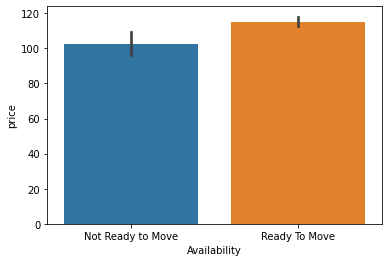

In [179]:
sns.barplot(x='Availability',y='price',data=data_1)
plt.show()

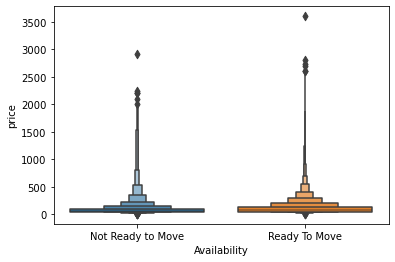

In [180]:
sns.boxenplot(x='Availability',y='price',data=data_1)
plt.show()

Although the price seems higher in the barchart for ready to move houses, we can see in the boxenplots that the prices remain consistent for both kinds of houses.<br>
We can try simple binary encoder for this column

## Fill in missing values

In [181]:
data_1['size'].fillna('0 BHK',inplace=True)

In [182]:
data_1['Size_1']=[int(k[0]) for k in data_1['size'].str.split(' ')]

In [183]:
data_1[data_1['Size_1']==0]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,Availability,Size_1
579,Plot Area,Immediate Possession,Sarjapur Road,0 BHK,Asiss B,1200 - 2400,NaN,NaN,34.185,Ready To Move,0
1775,Plot Area,Immediate Possession,IVC Road,0 BHK,Orana N,2000 - 5634,NaN,NaN,124.000,Ready To Move,0
2264,Plot Area,Immediate Possession,Banashankari,0 BHK,NaN,2400,NaN,NaN,460.000,Ready To Move,0
2809,Plot Area,Immediate Possession,Sarjapur Road,0 BHK,AsdiaAr,1200 - 2400,NaN,NaN,28.785,Ready To Move,0
2862,Plot Area,Immediate Possession,Devanahalli,0 BHK,Ajleyor,1500 - 2400,NaN,NaN,46.800,Ready To Move,0
5333,Plot Area,Immediate Possession,Devanahalli,0 BHK,Emngs S,2100 - 5405,NaN,NaN,177.115,Ready To Move,0
6423,Plot Area,Immediate Possession,Whitefield,0 BHK,SRniaGa,2324,NaN,NaN,26.730,Ready To Move,0
6636,Plot Area,Immediate Possession,Jigani,0 BHK,S2enste,1500,NaN,NaN,25.490,Ready To Move,0
6719,Plot Area,Immediate Possession,Hoskote,0 BHK,SJowsn,800 - 2660,NaN,NaN,28.545,Ready To Move,0
7680,Plot Area,Immediate Possession,Kasavanhalli,0 BHK,NaN,5000,NaN,NaN,400.000,Ready To Move,0


In [184]:
bath_balc_mean=np.round(data_1.groupby('Size_1').agg({'bath':'mean','balcony':'mean'}))
bath_balc_mean

,bath,balcony
Size_1,,
0,NaN,NaN
1,1.0,1.0
2,2.0,1.0
3,3.0,2.0
4,4.0,2.0
5,5.0,2.0
6,6.0,2.0
7,6.0,2.0
8,7.0,2.0


Fill missing values with 0

In [185]:
data_1.loc[data_1['bath'].isnull(),'bath']=0
data_1.loc[data_1['balcony'].isnull(),'balcony']=0

In [186]:
data_1.isnull().sum()

area_type          0
availability       0
location           1
size               0
society         5502
total_sqft         0
bath               0
balcony            0
price              0
Availability       0
Size_1             0
dtype: int64

In [187]:
data_1=data_1.drop('society',axis=1)
data_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,Availability,Size_1
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,Not Ready to Move,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,Ready To Move,4
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,Ready To Move,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,Ready To Move,3
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00,Ready To Move,2


In [188]:
data_1.drop(['availability','size'],axis=1,inplace=True)
data_1.head()

,area_type,location,total_sqft,bath,balcony,price,Availability,Size_1
0,Super built-up Area,Electronic City Phase II,1056,2.0,1.0,39.07,Not Ready to Move,2
1,Plot Area,Chikka Tirupathi,2600,5.0,3.0,120.00,Ready To Move,4
2,Built-up Area,Uttarahalli,1440,2.0,3.0,62.00,Ready To Move,3
3,Super built-up Area,Lingadheeranahalli,1521,3.0,1.0,95.00,Ready To Move,3
4,Super built-up Area,Kothanur,1200,2.0,1.0,51.00,Ready To Move,2


In [189]:
data_1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [190]:
ordinal=OrdinalEncoder(categories=[['Carpet  Area','Super built-up  Area','Built-up  Area','Plot  Area']])

In [191]:
data_1['Area_enc']=ordinal.fit_transform(data_1['area_type'].values.reshape([-1,1]))

In [192]:
data_1.drop('area_type',axis=1,inplace=True)
data_1.head()

,location,total_sqft,bath,balcony,price,Availability,Size_1,Area_enc
0,Electronic City Phase II,1056,2.0,1.0,39.07,Not Ready to Move,2,1.0
1,Chikka Tirupathi,2600,5.0,3.0,120.00,Ready To Move,4,3.0
2,Uttarahalli,1440,2.0,3.0,62.00,Ready To Move,3,2.0
3,Lingadheeranahalli,1521,3.0,1.0,95.00,Ready To Move,3,1.0
4,Kothanur,1200,2.0,1.0,51.00,Ready To Move,2,1.0


In [195]:
data_1.loc[data_1['location'].isnull(),'location']=data_1['location'].mode().values[0]

In [196]:
data_1.isnull().sum()

location        0
total_sqft      0
bath            0
balcony         0
price           0
Availability    0
Size_1          0
Area_enc        0
dtype: int64

In [197]:
data_1['Availability'].replace({'Not Ready to Move':0,'Ready To Move':1},inplace=True)
data_1.head()

,location,total_sqft,bath,balcony,price,Availability,Size_1,Area_enc
0,Electronic City Phase II,1056,2.0,1.0,39.07,0,2,1.0
1,Chikka Tirupathi,2600,5.0,3.0,120.00,1,4,3.0
2,Uttarahalli,1440,2.0,3.0,62.00,1,3,2.0
3,Lingadheeranahalli,1521,3.0,1.0,95.00,1,3,1.0
4,Kothanur,1200,2.0,1.0,51.00,1,2,1.0


**Location**<br>
It can be classified into North, South, East, West and Central Bangalore. This will bring the number of categories down and we can try to one hot encode the values

In [198]:
data_1['location'].value_counts()

Whitefield                                            541
Sarjapur  Road                                        399
Electronic City                                       302
Kanakpura Road                                        273
Thanisandra                                           234
Yelahanka                                             213
Uttarahalli                                           186
Hebbal                                                177
Marathahalli                                          175
Raja Rajeshwari Nagar                                 171
Hennur Road                                           152
Bannerghatta Road                                     152
7th Phase JP Nagar                                    149
Haralur Road                                          142
Electronic City Phase II                              132
Rajaji Nagar                                          107
Chandapura                                            100
Bellandur     

localities.csv was created by me. In this file all the localites are classified based on the location.

In [199]:
localities=pd.read_csv('localities.csv',header=0)
localities.head()

,North Bangalore,South Bangalore,Unnamed: 2,East Bangalore,West Bangalore,Unnamed: 5,Central Bangalore
0,Yeshwanthpur,Padmanabha Nagar,NaN,Marathahalli-Sarjapur Outer Ring Road,Bapuji Nagar,NaN,Cunningham Road
1,Yerthiganahalli,Tilak Nagar,NaN,Bellandur Outer Ring Road,Basaveshwara Nagar,NaN,MG Road
2,Yerappanahalli,Yelanahalli,NaN,Marathahalli,Bidadi,NaN,Benson Town
3,Yelahanka New Town,Singasandra,NaN,Haralur Road,Chandra Layout,NaN,Cambridge Layout
4,Yelahanka Airforce Road,Nagegowdanapalya,NaN,Kundalahalli,Kengeri,NaN,Chickpet


In [200]:
localities.isnull().sum()

North Bangalore       36
South Bangalore        0
Unnamed: 2           232
East Bangalore        59
West Bangalore       147
Unnamed: 5           232
Central Bangalore    136
dtype: int64

In [201]:
location=[]
for loc in data_1['location']:
    if loc in localities['North Bangalore'].values:
        location.append('North Bangalore')
    elif loc in localities['South Bangalore'].values:
        location.append('South Bangalore')
    elif loc in localities['East Bangalore'].values:
        location.append('East Bangalore')
    elif loc in localities['West Bangalore'].values:
        location.append('West Bangalore')
    elif loc in localities['Central Bangalore'].values:
        location.append('Central Bangalore')
    else:
        location.append('Other')
        

In [202]:
location=pd.DataFrame(location,columns=['locations'])

In [203]:
data_1=pd.concat([data_1,location],axis=1)
data_1.head()

,location,total_sqft,bath,balcony,price,Availability,Size_1,Area_enc,locations
0,Electronic City Phase II,1056,2.0,1.0,39.07,0,2,1.0,South Bangalore
1,Chikka Tirupathi,2600,5.0,3.0,120.00,1,4,3.0,East Bangalore
2,Uttarahalli,1440,2.0,3.0,62.00,1,3,2.0,South Bangalore
3,Lingadheeranahalli,1521,3.0,1.0,95.00,1,3,1.0,South Bangalore
4,Kothanur,1200,2.0,1.0,51.00,1,2,1.0,North Bangalore


In [204]:
data_1.drop(['location'],axis=1,inplace=True)
data_1.head()

,total_sqft,bath,balcony,price,Availability,Size_1,Area_enc,locations
0,1056,2.0,1.0,39.07,0,2,1.0,South Bangalore
1,2600,5.0,3.0,120.00,1,4,3.0,East Bangalore
2,1440,2.0,3.0,62.00,1,3,2.0,South Bangalore
3,1521,3.0,1.0,95.00,1,3,1.0,South Bangalore
4,1200,2.0,1.0,51.00,1,2,1.0,North Bangalore


In [208]:
one_hot=OneHotEncoder(handle_unknown='ignore',sparse=False)

In [211]:
loc_enc=pd.DataFrame(one_hot.fit_transform(data_1[['locations']]),index=data_1.index,columns=one_hot.categories_)

In [212]:
data_1=pd.concat([data_1,loc_enc],axis=1)
data_1.head()

,total_sqft,bath,balcony,price,Availability,Size_1,Area_enc,locations,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)"
0,1056,2.0,1.0,39.07,0,2,1.0,South Bangalore,0.0,0.0,0.0,0.0,1.0,0.0
1,2600,5.0,3.0,120.00,1,4,3.0,East Bangalore,0.0,1.0,0.0,0.0,0.0,0.0
2,1440,2.0,3.0,62.00,1,3,2.0,South Bangalore,0.0,0.0,0.0,0.0,1.0,0.0
3,1521,3.0,1.0,95.00,1,3,1.0,South Bangalore,0.0,0.0,0.0,0.0,1.0,0.0
4,1200,2.0,1.0,51.00,1,2,1.0,North Bangalore,0.0,0.0,1.0,0.0,0.0,0.0


In [213]:
data_1.drop('locations',axis=1,inplace=True)

In [214]:
data_1.head()

,total_sqft,bath,balcony,price,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)"
0,1056,2.0,1.0,39.07,0,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2600,5.0,3.0,120.00,1,4,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1440,2.0,3.0,62.00,1,3,2.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1521,3.0,1.0,95.00,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1200,2.0,1.0,51.00,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [257]:
area=data_1['total_sqft'].str.split('-')
area_num=[]
for i in area:
    ar=[]
    c=0
    for j in i[0]:
        if j.isalpha():
            c=c+1
            break
        ar.append(j)
    if c==1:
        if 'Acres' in i[0]:
            area_num.append(float(''.join(ar))*43560)
        elif 'Sq. Meter' in i[0]:
            area_num.append(float(''.join(ar))*10.7639)
        elif 'Sq. Yards' in i[0]:
            area_num.append(float(''.join(ar))*9)
        elif 'Guntha' in i[0]:
            area_num.append(float(''.join(ar))*1089)
        elif 'Cents' in i[0]:
            area_num.append(float(''.join(ar))*435.36)
        else:
            area_num.append(float(''.join(ar)))
    else:
        area_num.append(float(''.join(ar)))
    

In [259]:
data_1.shape

(13320, 13)

In [260]:
len(area_num)

13320

In [261]:
data_1['Area sqft']=area_num
data_1.drop('total_sqft',axis=1,inplace=True)
data_1.head()

,bath,balcony,price,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft
0,2.0,1.0,39.07,0,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1056.0
1,5.0,3.0,120.00,1,4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2600.0
2,2.0,3.0,62.00,1,3,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1440.0
3,3.0,1.0,95.00,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1521.0
4,2.0,1.0,51.00,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1200.0


In [335]:
X=data_1.drop('price',axis=1)
y=data_1['price']

In [278]:
X.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft
0,2.0,1.0,0,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1056.0
1,5.0,3.0,1,4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2600.0
2,2.0,3.0,1,3,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1440.0
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1521.0
4,2.0,1.0,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1200.0


In [263]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [264]:
linear=LinearRegression()

In [265]:
model_linear=linear.fit(X_train,y_train)

In [266]:
def metrics(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    return rmse

In [267]:
metrics(model_linear)

134.90310945637032

In [269]:
data_test=pd.read_csv('test_redone.csv',index_col=0)
data_test.head()

,area_type,bath,balcony,Availability,Size_1,locations,Area sqft
0,Super built-up Area,2.0,2.0,1,2,East Bangalore,1225.0
1,Plot Area,9.0,2.0,1,9,Other,2400.0
2,Plot Area,5.0,2.0,0,4,North Bangalore,1650.0
3,Super built-up Area,3.0,1.0,1,3,South Bangalore,1322.0
4,Super built-up Area,2.0,1.0,1,2,South Bangalore,1161.0


In [273]:
data_test['Area_enc']=ordinal.transform(data_test[['area_type']])

In [275]:
loc=pd.DataFrame(one_hot.transform(data_test[['locations']]),index=data_test.index,columns=one_hot.categories_)

In [276]:
data_test=pd.concat([data_test,loc],axis=1)
data_test.head()

,area_type,bath,balcony,Availability,Size_1,locations,Area sqft,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)"
0,Super built-up Area,2.0,2.0,1,2,East Bangalore,1225.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Plot Area,9.0,2.0,1,9,Other,2400.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Plot Area,5.0,2.0,0,4,North Bangalore,1650.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Super built-up Area,3.0,1.0,1,3,South Bangalore,1322.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Super built-up Area,2.0,1.0,1,2,South Bangalore,1161.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [277]:
data_test.drop(['area_type','locations'],axis=1,inplace=True)
data_test.head()

,bath,balcony,Availability,Size_1,Area sqft,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)"
0,2.0,2.0,1,2,1225.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,9.0,2.0,1,9,2400.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5.0,2.0,0,4,1650.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,1.0,1,3,1322.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,1,2,1161.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [280]:
area_sqft=data_test['Area sqft']
data_test.drop('Area sqft',axis=1,inplace=True)
data_test.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)"
0,2.0,2.0,1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,9.0,2.0,1,9,3.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5.0,2.0,0,4,3.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [281]:
data_test=pd.concat([data_test,area_sqft],axis=1)
data_test.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft
0,2.0,2.0,1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1225.0
1,9.0,2.0,1,9,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2400.0
2,5.0,2.0,0,4,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1650.0
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1322.0
4,2.0,1.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1161.0


In [282]:
X_train.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft
3349,3.0,2.0,0,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2000.0
2909,3.0,2.0,1,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2401.0
8229,3.0,2.0,1,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1870.0
42,1.0,0.0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,600.0
801,0.0,0.0,0,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4000.0


In [284]:
y_pred=model_linear.predict(data_test)

In [286]:
sub_1=pd.DataFrame(y_pred,index=data_test.index,columns=['price'])

In [287]:
sub_1.to_csv('Sub_1.csv')

## Trying Deep Learning

In [352]:
model_dl=Sequential()

model_dl.add(Dense(12,activation=LeakyReLU(0.3),input_shape=[X_train.shape[1]]))
model_dl.add(Dense(5,activation=LeakyReLU(0.3)))
model_dl.add(Dense(1))


In [353]:
model_dl.compile(optimizer='rmsprop',loss='mse',metrics=['mse','mae'])

In [354]:
model_dl.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 65        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 6         
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________


In [355]:
callback=EarlyStopping(monitor='val_mae',patience=10)
history=model_dl.fit(X_train,y_train,epochs=1000,validation_data=[X_test,y_test],callbacks=[callback])

Train on 9324 samples, validate on 3996 samples
Epoch 1/1000
9324/9324 [==============================] - 1s 66us/sample - loss: 175494.4536 - mse: 175494.4219 - mae: 139.2612 - val_loss: 593011.2510 - val_mse: 593011.1875 - val_mae: 82.2603
Epoch 2/1000
9324/9324 [==============================] - 0s 48us/sample - loss: 77267.5947 - mse: 77267.5938 - mae: 70.1844 - val_loss: 1194272.6695 - val_mse: 1194272.7500 - val_mae: 74.7058
Epoch 3/1000
9324/9324 [==============================] - 0s 48us/sample - loss: 111644.6457 - mse: 111644.6719 - mae: 64.2722 - val_loss: 4085387.8695 - val_mse: 4085388.0000 - val_mae: 113.3960
Epoch 4/1000
9324/9324 [==============================] - 0s 51us/sample - loss: 190294.3076 - mse: 190294.2656 - mae: 59.4725 - val_loss: 1799394.9186 - val_mse: 1799394.3750 - val_mae: 79.1077
Epoch 5/1000
9324/9324 [==============================] - 0s 52us/sample - loss: 97147.5901 - mse: 97147.5859 - mae: 57.9321 - val_loss: 273697.3466 - val_mse: 273697.3438 - 

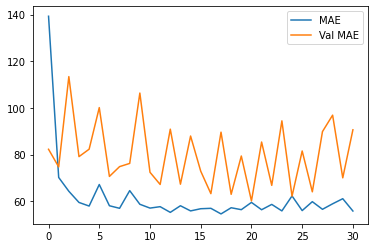

In [356]:
plt.plot(history.history['mae'],label='MAE')
plt.plot(history.history['val_mae'],label='Val MAE')
plt.legend(loc='best')
plt.show()

In [357]:
y_pred=model_dl.predict(data_test)

In [358]:
sub_3=pd.DataFrame(y_pred,index=data_test.index,columns=['price'])

In [359]:
sub_3.to_csv('Sub_3.csv')

## Including the society column
Usually houses that belong to a society tends to cost more. So we shall encode this column with only those that are in the society (1) and those that aren't in a soceity (0)

In [387]:
society=data['society'].fillna('None')
X['Society']=society.apply(lambda k:0 if k=='None' else 1)

In [388]:
X.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft,Society
0,2.0,1.0,0,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1056.0,1
1,5.0,3.0,1,4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2600.0,1
2,2.0,3.0,1,3,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1440.0,0
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1521.0,1
4,2.0,1.0,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1200.0,0


C:\Users\j\Anaconda3\envs\dl_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Society', ylabel='price'>

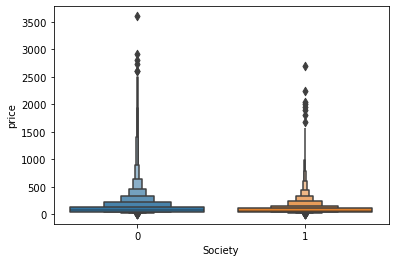

In [399]:
sns.boxenplot(X['Society'],y)

In [389]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [390]:
X_train.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft,Society
3349,3.0,2.0,0,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2000.0,0
2909,3.0,2.0,1,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2401.0,0
8229,3.0,2.0,1,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1870.0,1
42,1.0,0.0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,600.0,1
801,0.0,0.0,0,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4000.0,1


In [391]:
model_dl1=Sequential()

model_dl1.add(Dense(10,activation=LeakyReLU(0.3),input_shape=[X_train.shape[1]]))
model_dl1.add(Dense(1))

In [392]:
model_dl1.compile(optimizer='adam',loss='mae',metrics=['mse','mae'])

In [393]:
history=model_dl1.fit(X_train,y_train,epochs=1000,validation_data=[X_test,y_test],callbacks=[callback])

Train on 9324 samples, validate on 3996 samples
Epoch 1/1000
9324/9324 [==============================] - 1s 61us/sample - loss: 58.0359 - mse: 184973.9688 - mae: 58.0359 - val_loss: 77.9020 - val_mse: 1763413.3750 - val_mae: 77.9019
Epoch 2/1000
9324/9324 [==============================] - 1s 55us/sample - loss: 53.3823 - mse: 203407.6094 - mae: 53.3824 - val_loss: 79.1629 - val_mse: 1911292.8750 - val_mae: 79.1629
Epoch 3/1000
9324/9324 [==============================] - 0s 46us/sample - loss: 53.3489 - mse: 195914.1094 - mae: 53.3489 - val_loss: 78.1020 - val_mse: 1806225.5000 - val_mae: 78.1020
Epoch 4/1000
9324/9324 [==============================] - 0s 46us/sample - loss: 53.4494 - mse: 180825.5781 - mae: 53.4494 - val_loss: 80.1118 - val_mse: 2006143.2500 - val_mae: 80.1118
Epoch 5/1000
9324/9324 [==============================] - 0s 48us/sample - loss: 53.1436 - mse: 167758.5781 - mae: 53.1436 - val_loss: 78.9677 - val_mse: 1901909.3750 - val_mae: 78.9677
Epoch 6/1000
9324/9324

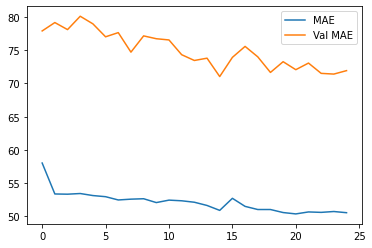

In [394]:
plt.plot(history.history['loss'],label='MAE')
plt.plot(history.history['val_loss'],label='Val MAE')
plt.legend(loc='best')
plt.show()

In [367]:
data_test.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft
0,2.0,2.0,1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1225.0
1,9.0,2.0,1,9,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2400.0
2,5.0,2.0,0,4,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1650.0
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1322.0
4,2.0,1.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1161.0


In [368]:
soc=pd.read_csv('Test.csv')
soc.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [383]:
soc_test=soc['society'].fillna('None')
soc_test=soc_test.apply(lambda k: 0 if k=='None' else 1)

In [384]:
data_test=pd.concat([data_test,soc_test],axis=1)
data_test.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft,society
0,2.0,2.0,1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1225.0,1
1,9.0,2.0,1,9,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2400.0,0
2,5.0,2.0,0,4,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1650.0,1
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1322.0,1
4,2.0,1.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1161.0,1


In [396]:
y_pred=model_dl1.predict(data_test)

In [397]:
sub_4=pd.DataFrame(y_pred,index=data_test.index,columns=['price'])
sub_4.to_csv('Sub_4.csv')

Based on Hackathon results this model has an accuracy of 0.81

In [403]:
loc_it=pd.read_csv('localities_IT.csv',header=0)
loc_it.head()

,North Bangalore,South Bangalore,East Bangalore,West Bangalore,Central Bangalore,IT Areas
0,Yeshwanthpur,Padmanabha Nagar,Banaswadi,Bapuji Nagar,Cunningham Road,Marathahalli-Sarjapur Outer Ring Road
1,Yerthiganahalli,Tilak Nagar,Basavanagar,Basaveshwara Nagar,MG Road,Bellandur Outer Ring Road
2,Yerappanahalli,Yelanahalli,Cooke Town,Bidadi,Benson Town,Marathahalli
3,Yelahanka New Town,Singasandra,Domlur,Chandra Layout,Cambridge Layout,Haralur Road
4,Yelahanka Airforce Road,Nagegowdanapalya,GM Palya,Kengeri,Chickpet,Kundalahalli


In [413]:
loc_data=data['location'].fillna(data['location'].mode()[0])
loc_data.isnull().sum()

0

In [414]:
location=[]
for loc in loc_data:
    if loc in loc_it['North Bangalore'].values:
        location.append('North Bangalore')
    elif loc in loc_it['South Bangalore'].values:
        location.append('South Bangalore')
    elif loc in loc_it['East Bangalore'].values:
        location.append('East Bangalore')
    elif loc in loc_it['West Bangalore'].values:
        location.append('West Bangalore')
    elif loc in loc_it['Central Bangalore'].values:
        location.append('Central Bangalore')
    elif loc in loc_it['IT Areas'].values:
        location.append('IT Areas')
    else:
        location.append('Other')
        

In [417]:
data_2=data_1.drop([('Central Bangalore',),    ('East Bangalore',),   ('North Bangalore',),
                   ('Other',),   ('South Bangalore',),    ('West Bangalore',)],axis=1)
data_2.head()

,bath,balcony,price,Availability,Size_1,Area_enc,Area sqft
0,2.0,1.0,39.07,0,2,1.0,1056.0
1,5.0,3.0,120.00,1,4,3.0,2600.0
2,2.0,3.0,62.00,1,3,2.0,1440.0
3,3.0,1.0,95.00,1,3,1.0,1521.0
4,2.0,1.0,51.00,1,2,1.0,1200.0


In [418]:
loc_2=pd.DataFrame(location,index=data_2.index,columns=['Location'])
data_2=pd.concat([data_2,loc_2],axis=1)

In [419]:
data_2.head()

,bath,balcony,price,Availability,Size_1,Area_enc,Area sqft,Location
0,2.0,1.0,39.07,0,2,1.0,1056.0,IT Areas
1,5.0,3.0,120.00,1,4,3.0,2600.0,East Bangalore
2,2.0,3.0,62.00,1,3,2.0,1440.0,South Bangalore
3,3.0,1.0,95.00,1,3,1.0,1521.0,South Bangalore
4,2.0,1.0,51.00,1,2,1.0,1200.0,North Bangalore


In [422]:
one_hot_2=OneHotEncoder(sparse=False,handle_unknown='ignore')
loc_enc=pd.DataFrame(one_hot_2.fit_transform(data_2[['Location']]),index=data_2.index,columns=one_hot_2.categories_)

In [423]:
data_2=pd.concat([data_2,loc_enc],axis=1)
data_2.drop('Location',axis=1,inplace=True)
data_2.head()

,bath,balcony,price,Availability,Size_1,Area_enc,Area sqft,"(Central Bangalore,)","(East Bangalore,)","(IT Areas,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)"
0,2.0,1.0,39.07,0,2,1.0,1056.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.0,3.0,120.00,1,4,3.0,2600.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,3.0,62.00,1,3,2.0,1440.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.0,1.0,95.00,1,3,1.0,1521.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,51.00,1,2,1.0,1200.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [434]:
X=data_2.drop('price',axis=1)
society=data['society'].fillna('None')
X['Society']=society.apply(lambda k:0 if k=='None' else 1)
y=data_2['price']

In [435]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [439]:
model_dl2=Sequential()

model_dl2.add(Dense(10,activation=LeakyReLU(0.3),input_shape=[X_train.shape[1]]))
model_dl2.add(Dense(1))

In [440]:
model_dl2.compile(optimizer='adam',loss='mae',metrics=['mse','mae'])

history=model_dl2.fit(X_train,y_train,epochs=1000,validation_data=[X_test,y_test],callbacks=[callback])

Train on 9324 samples, validate on 3996 samples
Epoch 1/1000
9324/9324 [==============================] - 1s 59us/sample - loss: 150.1114 - mse: 310156.5938 - mae: 150.1114 - val_loss: 78.7943 - val_mse: 1807511.8750 - val_mae: 78.7943
Epoch 2/1000
9324/9324 [==============================] - 1s 59us/sample - loss: 53.6516 - mse: 176790.7344 - mae: 53.6516 - val_loss: 77.0310 - val_mse: 1662173.7500 - val_mae: 77.0310
Epoch 3/1000
9324/9324 [==============================] - 0s 48us/sample - loss: 53.3884 - mse: 163278.4375 - mae: 53.3884 - val_loss: 75.8835 - val_mse: 1565532.8750 - val_mae: 75.8835
Epoch 4/1000
9324/9324 [==============================] - 0s 47us/sample - loss: 52.7183 - mse: 143972.6094 - mae: 52.7183 - val_loss: 76.2388 - val_mse: 1605174.6250 - val_mae: 76.2388
Epoch 5/1000
9324/9324 [==============================] - 0s 47us/sample - loss: 52.8007 - mse: 147136.3906 - mae: 52.8006 - val_loss: 74.2163 - val_mse: 1429939.6250 - val_mae: 74.2163
Epoch 6/1000
9324/93

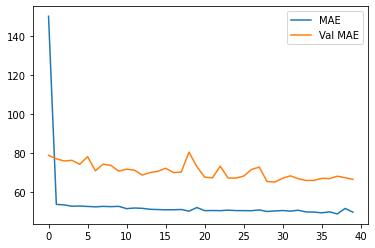

In [441]:
plt.plot(history.history['loss'],label='MAE')
plt.plot(history.history['val_loss'],label='Val MAE')
plt.legend(loc='best')
plt.show()

In [442]:
data_test.head()

,bath,balcony,Availability,Size_1,Area_enc,"(Central Bangalore,)","(East Bangalore,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Area sqft,society
0,2.0,2.0,1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1225.0,1
1,9.0,2.0,1,9,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2400.0,0
2,5.0,2.0,0,4,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1650.0,1
3,3.0,1.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1322.0,1
4,2.0,1.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1161.0,1


In [458]:
X_train.head()

,bath,balcony,Availability,Size_1,Area_enc,Area sqft,"(Central Bangalore,)","(East Bangalore,)","(IT Areas,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",Society
3349,3.0,2.0,0,3,1.0,2000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2909,3.0,2.0,1,3,1.0,2401.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
8229,3.0,2.0,1,3,1.0,1870.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
42,1.0,0.0,1,1,1.0,600.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
801,0.0,0.0,0,4,1.0,4000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [461]:
data_test_1=data_test.drop([('Central Bangalore',),    ('East Bangalore',),   ('North Bangalore',),
                   ('Other',),   ('South Bangalore',),    ('West Bangalore',),'society'],axis=1)

In [462]:
data_test_1.head()

,bath,balcony,Availability,Size_1,Area_enc,Area sqft
0,2.0,2.0,1,2,1.0,1225.0
1,9.0,2.0,1,9,3.0,2400.0
2,5.0,2.0,0,4,3.0,1650.0
3,3.0,1.0,1,3,1.0,1322.0
4,2.0,1.0,1,2,1.0,1161.0


In [456]:
location=[]
for loc in soc['location']:
    if loc in loc_it['North Bangalore'].values:
        location.append('North Bangalore')
    elif loc in loc_it['South Bangalore'].values:
        location.append('South Bangalore')
    elif loc in loc_it['East Bangalore'].values:
        location.append('East Bangalore')
    elif loc in loc_it['West Bangalore'].values:
        location.append('West Bangalore')
    elif loc in loc_it['Central Bangalore'].values:
        location.append('Central Bangalore')
    elif loc in loc_it['IT Areas'].values:
        location.append('IT Areas')
    else:
        location.append('Other')
location=pd.DataFrame(location,index=data_test_1.index,columns=['Location'])

In [457]:
loc_df=pd.DataFrame(one_hot_2.transform(location[['Location']]),index=data_test_1.index,columns=one_hot_2.categories_)

In [463]:
data_test_1=pd.concat([data_test_1,loc_df,data_test['society']],axis=1)
data_test_1.head()

,bath,balcony,Availability,Size_1,Area_enc,Area sqft,"(Central Bangalore,)","(East Bangalore,)","(IT Areas,)","(North Bangalore,)","(Other,)","(South Bangalore,)","(West Bangalore,)",society
0,2.0,2.0,1,2,1.0,1225.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,9.0,2.0,1,9,3.0,2400.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,5.0,2.0,0,4,3.0,1650.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,3.0,1.0,1,3,1.0,1322.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,2.0,1.0,1,2,1.0,1161.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [464]:
y_pred=model_dl2.predict(data_test_1)
sub_5=pd.DataFrame(y_pred,index=data_test.index,columns=['price'])
sub_5.to_csv('Sub_5.csv')

This gives a value of 0.81525 in the Hackathon. This is a slight improvement from the earlier submission.